# Reliability and structure figures for MICrONS and BBP 
Figure 3 and Supplementary Figure S6 visualizing how reliability is shaped by the simplicial structure. 

In [1]:
# General 
import numpy as np
import pandas as pd
from scipy import stats
import pickle
# Connectomes and network analysis
import conntility
from connalysis.network import local 
from connalysis.network import stats as nstats

# Plotting
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
# Specific to this project
import sys 
sys.path.append('../../../library')
from preprocess import load_spike_trains, extract_binned_spike_signals
from dimensionality import get_spectrum_nbds, get_dimensions_nbds, get_dimensions
from structural_basic import *


### Load and format data 

In [2]:
# Loading structural data 
conns=["MICrONS", "BBP"]
# Get connectome 
connectomes={}
for conn in conns:
    connectomes[conn]=load_connectome("../../data", conn)
# Structural properties of neighborhoods
nbd_props={}
for conn in conns:
    nbd_props[conn]=pd.read_pickle(f'/gpfs/bbp.cscs.ch/home/egassant/reliability_and_structure/data_analysis/data/props_{conn}_original.pkl')

# Adding layer groups to vertex properties
layers=["L23", "L4", "L5", "L6"] 
layer_mytpes={"23P":"L23",
              "4P":"L4",
              "5P_IT":"L5",
              "5P_NP":"L5",
              "5P_PT":"L5",
              "6IT":"L6",
              "6CT":"L6", 
              'BPC':np.nan
             }
layer_grouping={2: "L23", 
               3: "L23", 
               4:"L4", 
               5:"L5", 
               6:"L6"}
connectomes["MICrONS"].add_vertex_property(new_label="layer_group",  
                                           new_values=[layer_mytpes[x] for x in connectomes["MICrONS"].vertices["cell_type"]])
connectomes["BBP"].add_vertex_property(new_label="layer_group",  
                                       new_values=[layer_grouping[x] for x in connectomes["BBP"].vertices["layer"]])
# Adding layers to nbd props
for conn in conns:
    nbd_props[conn]["layer"]=connectomes[conn].vertices["layer_group"]


In [3]:
# Loading acivity
# BBP Gaussian kernel values
fname="/gpfs/bbp.cscs.ch/data/scratch/proj9/bisimplices/simulations/BlobStimReliability_O1v5-SONATA_Baseline"
rel_path=f'{fname}/working_dir/reliability_basic.npz'
nbd_props["BBP"]["reliability"]=np.load(rel_path)['reliability']
# MICrONS
# Add oracle score data
df_act=pd.read_pickle('/gpfs/bbp.cscs.ch/project/proj96/home/ecker/assemblyfire/MICrONS/MICrONS_functional_summary.pkl')
# z-score each session to allow averaging
nbd_props["MICrONS"]["reliability"]=stats.zscore(df_act.T.xs('oracle_score', level=1), axis=1, nan_policy="omit").mean(axis=0)


In [4]:
# Get top and bottom complexity neighborhoods with active centers
tresh={"MICrONS":0.05, "BBP":0.05}
# Matching sample size of 100
tresh={conn: 100/(~np.isnan(nbd_props[conn]["reliability"])).sum() for conn in conns}

complexity_metric="wasserstein_deg_total"
for conn in conns:
    # Restrict to centers with registered activity
    x=(nbd_props[conn][~np.isnan(nbd_props[conn]['reliability'])])["wasserstein_deg_total"] 
    nbd_props[conn]['nbd_complexity']=np.nan
    # Sparse ones
    nbd_props[conn]['nbd_complexity'][nbd_props[conn][complexity_metric]<np.quantile(x, tresh[conn])]='low complexity'
    # Dense ones
    nbd_props[conn]['nbd_complexity'][nbd_props[conn][complexity_metric]>np.quantile(x, 1-tresh[conn])]='high complexity'

/gpfs/bbp.cscs.ch/ssd/slurmTmpFS/egassant/2066323/ipykernel_27364/2249603112.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nbd_props[conn]['nbd_complexity'][nbd_props[conn][complexity_metric]<np.quantile(x, tresh[conn])]='low complexity'
/gpfs/bbp.cscs.ch/ssd/slurmTmpFS/egassant/2066323/ipykernel_27364/2249603112.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nbd_props[conn]['nbd_complexity'][nbd_props[conn][complexity_metric]<np.quantile(x, tresh[conn])]='low complexity'


# Load reliability across simplices 

In [5]:
property="reliability"

stats_dict={}
for conn in conns:
    fname=f"../../data/node_stats_per_layer_{property}_{conn}_original.pkl"
    # Read dictionary pkl file
    with open(fname, 'rb') as fp:
        stats_dict[conn] = pickle.load(fp)


In [6]:
# Reformat data
def agg_along_dims(stats_dict, conn, prop, layers): 
    df={layer:{} for layer in layers}
    for layer in layers:
        for stype in stats_dict[conn][layer].keys():
            df[layer][stype]={"all":{}, "sink":{}, "source":{}}
            dims=stats_dict[conn][layer][stype].keys()
            dict = stats_dict[conn][layer][stype]
            for dim in dims: 
                mean=dict[dim]["mean"]
                err=dict[dim]["sem"]
                df[layer][stype]['all'][dim]=[mean.loc["all"], err.loc["all"]]
                df[layer][stype]['source'][dim]=[mean.iloc[0], err.iloc[0]]
                df[layer][stype]['sink'][dim]=[mean.iloc[-2], err.iloc[-2]]
            df[layer][stype]={key:pd.DataFrame.from_dict(df[layer][stype][key], orient="index", columns=["mean", "sem"]) 
                                for key in df[layer][stype].keys()}
    return df

simp_reliab={}
for conn in conns:
    simp_reliab[conn]=agg_along_dims(stats_dict, conn, property, layers)

# Plotting

In [7]:
# Figure settings and color schemes 
titlesize=8
labelsize=6
ticksize=6
conversion=2.54
#conversion=1.5

marker_size=2
linewidth=2; linewidth_base=1; linestyle_base="dotted"; alpha_base=0.75

# Setting up colors 
colors={
    'high complexity': 'tab:purple', 
    'low complexity': 'tab:cyan', 
    2:matplotlib.colormaps["Set3"](0),
    3:matplotlib.colormaps["Set3"](2),
    4:matplotlib.colormaps["Set3"](5),
    5:matplotlib.colormaps["Set3"](4),
    6:matplotlib.colormaps["Set3"](3),
    "all":"C0",
    "sink": "C1",
    "source":"C2",
    'BBP':"steelblue", 
    'MICrONS':"palevioletred"
}
markers={"all":"o",
       "sink": ">",
       "source":"<"}
alpha=0.25



In [8]:
def scatter_and_regress(ax, data, x_col, y_col, color, marker='o', marker_size=marker_size, label=None, color_regress=None, alpha=0.5):
    x=data[x_col]; y=data[y_col] 
    mask=np.logical_and(~np.isnan(y), ~np.isnan(x))
    regress=stats.linregress(x[mask],y[mask])
    if color_regress is None: color_regress=color
    ax.plot(x, x*regress.slope+regress.intercept, color=color_regress, label=f"{regress.rvalue:.2f}, {regress.pvalue:.2f}")
    ax.scatter(x, y, c=color, marker=marker,s=marker_size, label=f"{label}",alpha=alpha, zorder=10, rasterized=True )
    h, l = ax.get_legend_handles_labels()
    return ax, h, l


def plot_and_fill(ax, data, label, color, ms, marker, alpha): 
    ax.plot(df["mean"], marker=marker, label=label, ms=ms)
    ax.fill_between(data.index, data["mean"]-data["sem"], data["mean"]+data["sem"], alpha=alpha)

def plot_violin(ax, y):
    sns.violinplot(data=data, x="dummy", y=y, ax=ax,
                   hue="nbd_complexity", split=True, inner="quart", palette=colors, 
                  hue_order=["low complexity", "high complexity"])#,linewidth=0.001)
    ax.spines[["left", "top", "bottom"]].set_visible(False)
    #ax.yaxis.set_ticks_position("right")
    #ax.set_yticks([0.6, 0.9],labels=[0.6, 0.9], fontsize=ticksize)
    ax.set_xticks([])
    ax.set_xlabel('')
    #ax.set_ylabel('')'''
    return ax


# Supplementary Figure 

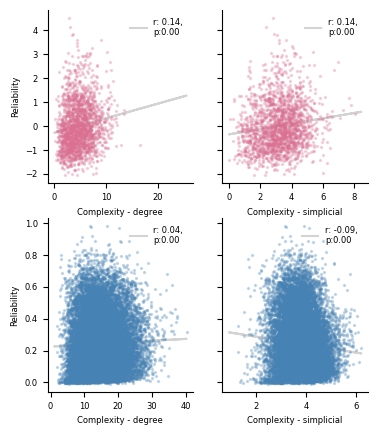

In [9]:
width=21*0.5/conversion

rows=2; cols=2
fig, axs =plt.subplots(rows,cols,figsize=(width, width*rows*1.2/cols), sharey='row')
property='reliability'
for i, conn in enumerate(conns):
    for j, (cpx, cpx_label) in enumerate([('wasserstein_deg_total', 'degree'),('euclidean_edges_sc', 'simplicial')]): 
        axs[i,j], h,l=scatter_and_regress(axs[i,j], nbd_props[conn], cpx, property, colors[conn], marker='o', 
                                          marker_size=marker_size, label=None, color_regress="lightgray", alpha=0.25)
        axs[i,j].legend([h[0]],[f"r: {l[0][:-4]}\np:{l[0][-4:]}"], frameon=False, fontsize=labelsize)

        
        axs[i,j].spines[["top", "right"]].set_visible(False)
        axs[i,j].set_xlabel(f"Complexity - {cpx_label}", fontsize=labelsize)
        axs[i,j].tick_params(axis='both', labelsize=ticksize)
    axs[i,0].set_ylabel(f"Reliability", fontsize=labelsize)
fig.savefig(f"figs/reliab_complexity_regression.svg", transparent=True, bbox_inches="tight")

# Main Figure

/gpfs/bbp.cscs.ch/ssd/slurmTmpFS/egassant/2066323/ipykernel_27364/3617842255.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["dummy"]=1
/gpfs/bbp.cscs.ch/ssd/slurmTmpFS/egassant/2066323/ipykernel_27364/3617842255.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["dummy"]=1


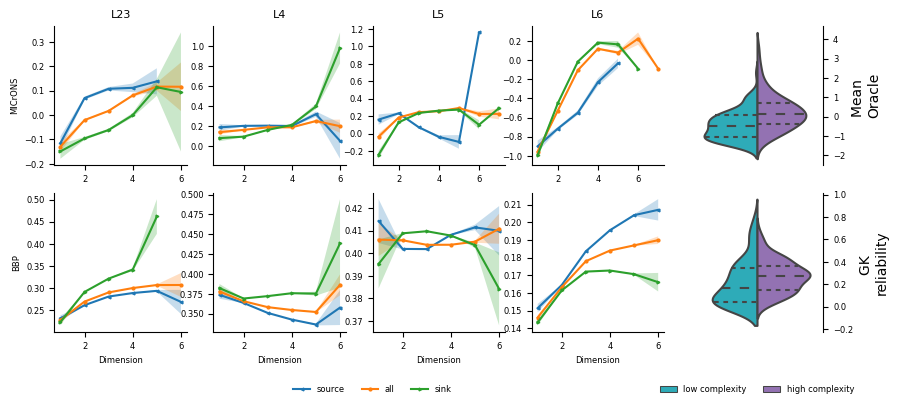

In [10]:
# Plotting figure prototype 
width=21*0.8/conversion

rows=2; cols=5
fig, axs =plt.subplots(rows,cols,figsize=(width*1.5, width*rows*1.5/cols), sharex=False, sharey=False)
# Efficiency and reliability across simplices 
stype="maximal" # Consider maximal simplices
for j, l in enumerate(layers):
    axs[0,j].set_title(f"{l}", fontsize=titlesize)
    for i, conn in enumerate(conns):
        for pos in ["source", "all", "sink"]:  
            df=simp_reliab[conn][l][stype][pos]
            plot_and_fill(axs[i,j], df, pos, colors[pos], marker_size, markers[pos], alpha=alpha)
            
        axs[i,j].spines[["top", "right"]].set_visible(False)
        axs[i,0].set_ylabel(conn, fontsize=labelsize)
        axs[1,j].set_xlabel("Dimension", fontsize=labelsize)


# Plotting violins of extremals
for i, conn in enumerate(conns):
    data=nbd_props[conn][np.logical_or(nbd_props[conn]["nbd_complexity"]=="high complexity", 
                                       nbd_props[conn]["nbd_complexity"]=="low complexity")]
    data["dummy"]=1
    axs[i,4]=plot_violin(axs[i,4], y=property)
    axs[i,4].get_legend().remove()
    axs[i,4].yaxis.tick_right()
    if conn=="MICrONS": 
        axs[i,4].set_ylabel("Mean \nOracle") 
    else:
        axs[i,4].set_ylabel("GK \nreliability") 
    axs[i,4].yaxis.set_label_position("right")

# Legends 
axs[1,4].legend(frameon=False,ncol=2, loc="lower center", bbox_to_anchor=(0.5,-0.5),fontsize=labelsize,)
axs[1,2].legend(frameon=False, fontsize=labelsize, ncol=3,loc=8, bbox_to_anchor=(0,-0.5) )


for ax in axs.flatten(): 
    ax.tick_params(axis='both', labelsize=ticksize)



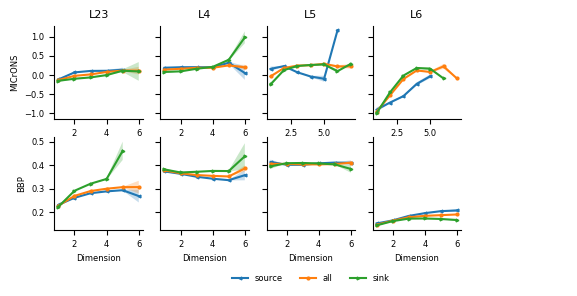

In [11]:
# Plotting simplicial structure
width=21*0.8/conversion

rows=2; cols=5
fig, axs =plt.subplots(rows,cols,figsize=(width, width*rows/cols), sharex=False, sharey="row")
# Efficiency and reliability across simplices 
stype="maximal" # Consider maximal simplices
for j, l in enumerate(layers):
    axs[0,j].set_title(f"{l}", fontsize=titlesize)
    for i, conn in enumerate(conns):
        for pos in ["source", "all", "sink"]:  
            df=simp_reliab[conn][l][stype][pos]
            plot_and_fill(axs[i,j], df, pos, colors[pos], marker_size, markers[pos], alpha=alpha)
            
        axs[i,j].spines[["top", "right"]].set_visible(False)
        axs[i,0].set_ylabel(conn, fontsize=labelsize)
        axs[1,j].set_xlabel("Dimension", fontsize=labelsize)


# Legends 
axs[1,2].legend(frameon=False, fontsize=labelsize, ncol=3,loc=8, bbox_to_anchor=(0.5,-0.65) )


for ax in axs.flatten(): 
    ax.tick_params(axis='both', labelsize=ticksize)

axs[0,4].axis("off")
axs[1,4].axis("off")

fig.savefig(f"figs/reliab_dimension_both_connectomes.pdf", transparent=True, bbox_inches="tight")


/gpfs/bbp.cscs.ch/ssd/slurmTmpFS/egassant/2066323/ipykernel_27364/1350201409.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["dummy"]=1
/gpfs/bbp.cscs.ch/ssd/slurmTmpFS/egassant/2066323/ipykernel_27364/1350201409.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["dummy"]=1




For connectome MICrONS
Sample size 100, 100
Kruskal-Wallis H-test KruskalResult(statistic=29.95582089552238, pvalue=4.420030007023841e-08)


For connectome BBP
Sample size 100, 100
Kruskal-Wallis H-test KruskalResult(statistic=10.012089552238763, pvalue=0.0015551597842851836)


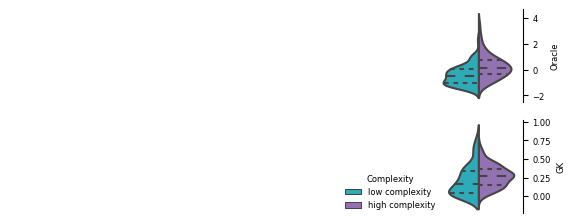

In [12]:
# Plotting extremals
width=21*0.8/conversion

rows=2; cols=5
fig, axs =plt.subplots(rows,cols,figsize=(width, width*rows/cols), sharex=False, sharey=False)


# Plotting violins of extremals
for i, conn in enumerate(conns):
    data=nbd_props[conn][np.logical_or(nbd_props[conn]["nbd_complexity"]=="high complexity", 
                                       nbd_props[conn]["nbd_complexity"]=="low complexity")]
    data["dummy"]=1
    # Test difference of means 
    x=data.query("nbd_complexity== 'low complexity'")["reliability"].to_numpy()
    y=data.query("nbd_complexity== 'high complexity'")["reliability"].to_numpy()
    x=x[~np.isnan(x)]; y=y[~np.isnan(y)]
    print(f"\n\nFor connectome {conn}")
    print(f"Sample size {x.shape[0]}, {y.shape[0]}")
    print(f"Kruskal-Wallis H-test {stats.kruskal(x, y)}")
    
    #Plot violins 
    axs[i,4]=plot_violin(axs[i,4], y=property)
    axs[i,4].get_legend().remove()
    axs[i,4].yaxis.tick_right()
    axs[i,4].tick_params(axis='both', labelsize=ticksize)

    if conn=="MICrONS": 
        axs[i,4].set_ylabel("Oracle",fontsize=labelsize) 
    else:
        axs[i,4].set_ylabel("GK",fontsize=labelsize) 
    axs[i,4].yaxis.set_label_position("right")

# Legends 
axs[1,4].legend(frameon=False,ncol=1, loc="upper center", bbox_to_anchor=(-0.5,0.5),fontsize=labelsize,
                title="Complexity", title_fontsize=labelsize)
axs[1,4].tick_params(axis='both', labelsize=ticksize)

for ax in axs[:, :-1].flatten():
    ax.axis("off")
fig.savefig(f"figs/reliab_extremals_both_connectomes.pdf", transparent=True, bbox_inches="tight")
